<a href="https://colab.research.google.com/github/QSBSC/QSBSC_Class_2020/blob/master/filtering_preprocessing_02Mar20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scRNA-seq Filtering & Preprocessing
02March2020

---
The purpose of this notebook is to walk through a typical **data cleaning** and **preprocessing** workflow for single-cell RNA-seq data. 

In [ ]:
%%time
# install necessary packages to the local environment
!pip install scanpy
!pip install leidenalg
# import packages for data manipulation and plotting
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

scRNA-seq suffers from high background noise, an artifact of **ambient** mRNA "leaking" out of dead/dying cells during the tissue dissociation process. This noise is complimented by the high dropout rate (**"Curse of Dimensionality"**) to create a need for strict filtering of the data to avoid misinterpretation.  
Typically, ambient genes can be identified within a run by their expression levels across all barcodes in the dataset. This allows us to identify **"empty droplets"** that contained an mRNA capture bead with no live cell, and remove them from the dataset prior to downstream processing.

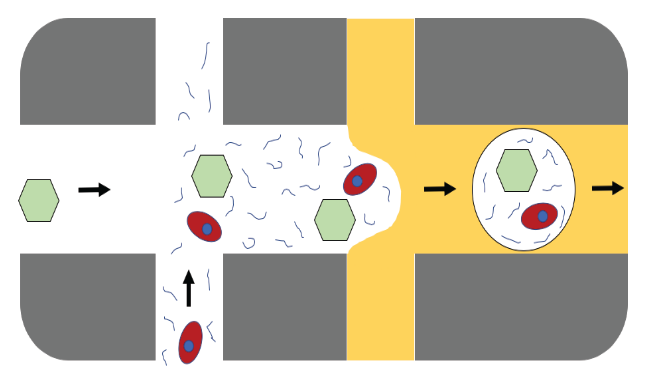

Diagram showing ambient RNA capture during scRNA-seq encapsulation.  

[Fleming, S. J., Marioni, J. C. and Babadi, M. (2019) ‘CellBender remove-background: a deep generative model for unsupervised removal of background noise from scRNA-seq datasets’, bioRxiv. Cold Spring Harbor Laboratory, p. 791699. doi: 10.1101/791699.](https://www.biorxiv.org/content/10.1101/791699v1)

There are a few general heuristics for distinguishing real cells from empty droplets in scRNA-seq data:
1. Genetic diversity (number of unique genes expressed)
2. Ambient gene expression (percentage of counts from highly-expressed, low-dropout genes)
3. Mitochondrial content (dead and dying cells; top ambient genes are usually mitochondrial)
4. Total mRNA content (**WARNING:** this one is the most deceptive. Many people tend to set hard cutoffs on total counts, which usually loses smaller cells with less total mRNA content, i.e. immune cells)

Let's start by pulling down an unfiltered dataset and looking at the distribution of the above heuristics. We will be using [**Scanpy**](https://icb-scanpy.readthedocs-hosted.com/en/stable/), the Python suite for single-cell data analysis.

**Scanpy** uses the [**AnnData**](https://icb-anndata.readthedocs-hosted.com/en/stable/anndata.AnnData.html) structure for each of its single-cell data objects. These are layered dataframes (numpy, scipy, pandas style) with linked **attributes** such as gene (*feature*) and cell (*observation*) names, as well as a bunch of easy, built-in **methods** for manipulating, exploring, and visualizing the data.

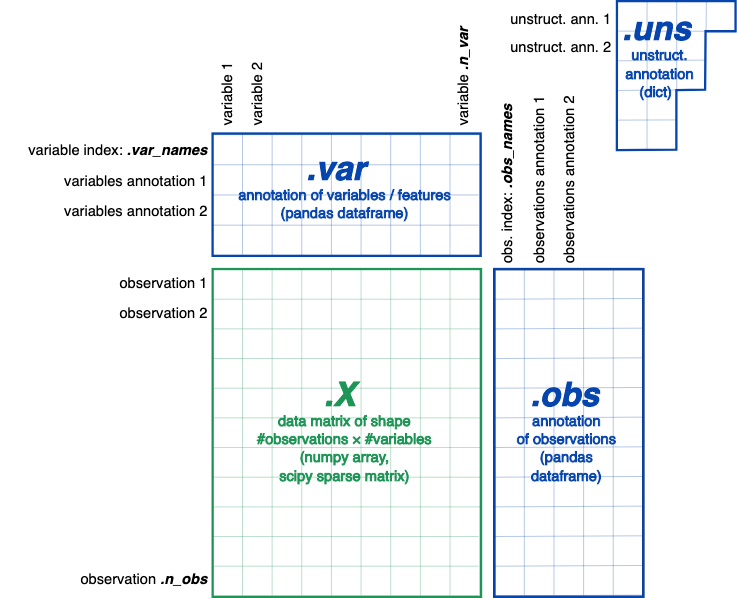

**AnnData** objects can be written to the `.h5ad` file format, specific to these data structures and based off the `.hdf5` compressed format. These are easy to read from and write to in Python as well as R's [**Seurat**](https://satijalab.org/seurat/) package.

In [ ]:
# download .h5ad file from GitHub
!wget https://raw.githubusercontent.com/bobchen1701/scRNAseqQC/classifier/data/3072-AS-2-CTTGTA_S2.h5ad

Read the downloaded `.h5ad` file into our working environment. We can call it by name to return an overview of its contents.

In [ ]:
adata = sc.read('3072-AS-2-CTTGTA_S2.h5ad')
adata

Now calculate some global heuristics using built-in scanpy methods.

In [ ]:
# identify mitochondrial genes by their name
adata.var["mito"] = adata.var_names.str.contains("^mt-|^MT-")

# identify putative ambient genes by lowest dropout pct (top 10)
adata.var["ambient"] = np.array(adata.X.astype(bool).sum(axis=0) / adata.n_obs).squeeze()
print(
    "Top 10 ambient genes have dropout rates between {} and {} percent:\n\t{}".format(
        round((1 - adata.var.ambient.nlargest(n=10).max()) * 100, 2),
        round((1 - adata.var.ambient.nlargest(n=10).min()) * 100, 2),
        adata.var.ambient.nlargest(n=10).index.tolist(),
        )
    )
adata.var["ambient"] = (adata.var.ambient >= adata.var.ambient.nlargest(n=10).min())

# calculate standard qc .obs and .var with scanpy preprocessing (pp) function
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito", "ambient"], inplace=True)

# we prefer an arcsinh transformation over log1p to avoid distortion of small (<10) counts values
# we'll calculate arcsinh-transformed global metrics for consistency...
adata.obs["arcsinh_total_counts"] = np.arcsinh(adata.obs["total_counts"])
adata.obs["arcsinh_n_genes_by_counts"] = np.arcsinh(adata.obs["n_genes_by_counts"])

# save a copy of the AnnData object with all cells for later
adata_orig = adata.copy()

Typically the ambient genes are also among the most highly-expressed across the whole dataset:

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=15)

Let's look at the distribution of some of the global metrics across our dataset.

In [ ]:
# define metrics to plot
thresholds=["arcsinh_n_genes_by_counts", "arcsinh_total_counts", "pct_counts_ambient", "pct_counts_mito"]

fig, axes = plt.subplots(ncols=len(thresholds), nrows=1, figsize=(len(thresholds) * 4, 4), sharey=True)
axes[0].set_ylabel("cells")
for i in range(len(thresholds)):
    axes[i].hist(adata.obs[thresholds[i]], bins=40)
    axes[i].set_title(thresholds[i])
fig.tight_layout()
plt.show()

Usually these **bimodal** distributions indicate that there are distinct "good" and "bad" populations in our dataset. The **empty droplets** are probably the ones with low `n_genes_by_counts` and `total_counts`, and high `pct_counts_ambient` and `pct_counts_mito`.

Now we'll define a convenience function for visualizing the cumulative distribution of mRNA counts.

In [ ]:
def find_inflection(
    ann_data, inflection_percentiles=[0, 15, 30, 100], output_prefix="Output"
):
    ann_data_cumsum = np.cumsum(ann_data.obs["total_counts"])
    x_vals = np.arange(0, ann_data.obs.shape[0])
    secant_coef = ann_data_cumsum[ann_data.obs.shape[0] - 1] / ann_data.obs.shape[0]
    secant_line = secant_coef * x_vals
    secant_dist = abs(ann_data_cumsum - secant_line)
    inflection_percentiles_inds = np.percentile(x_vals, inflection_percentiles).astype(
        int
    )
    inflection_points = secant_dist.argsort()[::-1]
    percentile_points = inflection_points[inflection_percentiles_inds]
    color = plt.cm.tab10(np.linspace(0, 1, ann_data.obs.shape[0]))
    plt.figure(figsize=(20, 10))
    plt.plot(np.array(ann_data_cumsum), label="Cumulative Sum")
    # plt.plot(np.array(secant_line), label="Secant Line")
    plt.plot(np.array(secant_dist), label="Secant Distance")
    for percentile in percentile_points:
        plt.axvline(
            x=percentile,
            ymin=0,
            c=color[percentile],
            linestyle="--",
            linewidth=2,
            label="Inflection point {}".format(percentile),
        )
    plt.legend()
    # save to file
    if output_prefix != "":
        plt.savefig(output_prefix + "_inflectionCheck.png", bbox_inches="tight")
    else:
        plt.show()
    print(
        "Inflection point at {} for {} percentiles of greatest secant distances".format(
            percentile_points, inflection_percentiles
        )
    )
    # SJCG: added the ability to return a dictionary of points
    return dict(zip(inflection_percentiles, percentile_points))


In [ ]:
# put cells in order of decreasing total counts
adata = adata[np.argsort(adata.obs["total_counts"])[::-1],:].copy()
# plot the cumulative total counts distribution and look for an "inflection point"
find_inflection(adata, output_prefix="", inflection_percentiles=[0, 35, 70])

The approximate inflection point is the **maximum of the orange curve**, which represents the distance from the blue curve to the secant line. We'll go beyond this point for our initial filter to hopefully capture all real cells and some empty barcodes/dead cells that we can gate out manually.

In [ ]:
sc.pp.filter_cells(adata, min_counts=adata.obs.iloc[7855].total_counts)
adata  # look at size and contents of pre-filtered data

Now we'll reduce dimensions of our data with PCA and visualize using UMAP.

In [ ]:
# save raw counts to .raw layer
adata.raw = adata.copy()

# first normalize each cell to the total counts to yield fractional expression of each gene
sc.pp.normalize_total(adata)
adata.layers["norm_counts"] = adata.X.copy()  # save normalized counts to .layers
sc.pp.log1p(adata)
adata.layers["log1p_norm"] = adata.X.copy()  # save log1p-transformed counts to .layers

# determine highly variable genes by their variance and dispersion
sc.pp.highly_variable_genes(adata, n_top_genes=2000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [ ]:
# perform an arcsinh-transformation on the normalized counts
# multiply each value by the median number of counts across the whole matrix
adata.X = adata.layers["norm_counts"].copy() # return the normalized counts to the .X working slot
adata.X = (np.arcsinh(adata.X) * np.median(adata.raw.X.sum(axis=1)))

# now scale each gene to unit variance with the mean centered at zero to avoid more variable genes from dominating the principal components
sc.pp.scale(adata)

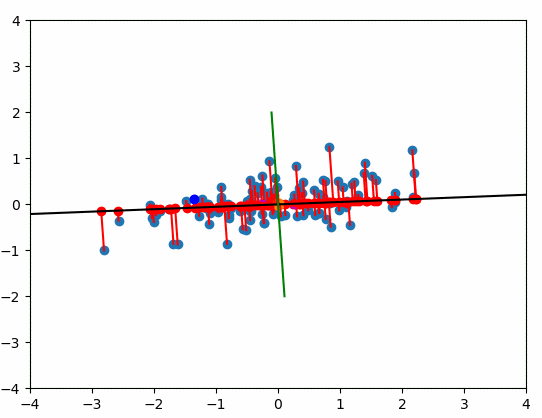

PCA allows us to reduce the dimensions of our data drastically by drawing axes through multidimensional space that **maximize variance** across the observations in the dataset. This results in a **linear combination** of genes that make up each PC.

In [ ]:
# perform 100-component PCA
sc.tl.pca(adata, n_comps=100)
sc.pl.pca(adata, color=['arcsinh_total_counts'], components=['1,2','1,3','2,3'])

In [ ]:
# examine variance captured by each principal component
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [ ]:
# look at top and bottom gene contributions to top three PCs
sc.pl.pca_loadings(adata)

Now we can visualize the data further using UMAP, which first requires a nearest-neighbor graph.

In [ ]:
# use square-root of total cells as neighborhood size
sc.pp.neighbors(adata, n_neighbors=int(np.sqrt(adata.n_obs)), n_pcs=30)
sc.tl.umap(adata)

In [ ]:
# plot marker genes to determine which clusters to keep or gate out
sc.pl.umap(
    adata,
    color=['Krt20','Muc2','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','pct_counts_ambient'],
    ncols=3,
    use_raw=False,
)

Next, let's use a graph-based clustering strategy ([Leiden](https://www.nature.com/articles/s41598-019-41695-z)) to identify sub-populations in the data that we may identify as dead cells or empty droplets.

In [ ]:
# resolution value determines the granularity of clustering
# higher resolution = smaller, refined clusters
# lower resolution = larger, coarse grained clusters
sc.tl.leiden(adata, resolution=1.5, random_state=1) 

In [ ]:
sc.pl.umap(adata, color='leiden')

Now we can pick the clusters we want to keep and add an observation to the original dataset.

In [ ]:
to_keep = adata.obs_names[np.where(adata.obs['leiden'].isin(['3','4','5','8','9','10','11','12','13','14','17','18','19','20']))[0]]

In [ ]:
to_keep

In [ ]:
adata_orig.obs["manual_filter"] = 0
adata_orig.obs.loc[to_keep, "manual_filter"] = 1

---
Using the manual labels from the above filtering, we can reduce dimensions, visualize the dataset, and determine **differentially-expressed (DE) genes** in each cluster.

In [ ]:
# define new AnnData with only manually filtered cells
adata_manual = adata_orig[adata_orig.obs.manual_filter==1,:]
adata_manual

In [ ]:
%%time
adata_manual.raw = adata_manual.copy()

# first normalize each cell to the total counts to yield fractional expression of each gene
sc.pp.normalize_total(adata_manual)
adata_manual.layers["norm_counts"] = adata_manual.X.copy()  # save normalized counts to .layers
sc.pp.log1p(adata_manual)
adata_manual.layers["log1p_norm"] = adata_manual.X.copy()  # save log1p-transformed counts to .layers

# determine highly variable genes by their variance and dispersion
sc.pp.highly_variable_genes(adata_manual, n_top_genes=2000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata_manual)

In [ ]:
%%time
# perform an arcsinh-transformation on the normalized counts
# multiply each value by the median number of counts across the whole matrix
adata_manual.X = adata_manual.layers["norm_counts"].copy() # return the normalized counts to the .X working slot
adata_manual.X = (np.arcsinh(adata_manual.X) * np.median(adata_manual.raw.X.sum(axis=1)))

# now scale each gene to unit variance with the mean centered at zero to avoid more variable genes from dominating the principal components
sc.pp.scale(adata_manual)

# perform 100-component PCA
sc.tl.pca(adata_manual, n_comps=100)
sc.pl.pca(adata_manual, color=['arcsinh_total_counts'], components=['1,2','1,3','2,3'])

In [ ]:
%%time
# use square-root of total cells as neighborhood size
sc.pp.neighbors(adata_manual, n_neighbors=int(np.sqrt(adata_manual.n_obs)), n_pcs=30)
sc.tl.umap(adata_manual)
sc.tl.leiden(adata_manual, resolution=1, random_state=1)

sc.pl.umap(
    adata_manual,
    color=['arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','pct_counts_ambient','leiden'],
    ncols=3,
    use_raw=False,
)

Use `sc.tl.rank_genes_groups()` method to determine differential expression in the Leiden clusters using the **Wilcoxon Rank-Sum test**

In [ ]:
sc.tl.rank_genes_groups(adata_manual, groupby="leiden", use_raw=False, layer="log1p_norm", method="wilcoxon")
sc.pl.rank_genes_groups(adata_manual)

---
### We have a filtered dataset!
But this process was pretty manual, and it seems like we accidentally kept a cluster of dead cells (Leiden 1).  Is there a way to automate this process, or use a model to more intelligently identify "good" and "bad" barcodes in our dataset?

In [ ]:
sc.pl.scatter(adata_orig, x='arcsinh_n_genes_by_counts', y='pct_counts_ambient', color='manual_filter')

Looks like the bulk of our chosen cells falls in the lower right quadrant of our **genes** vs. **ambient** plot. Let's try to use some basic automatic distribution thresholding from [**scikit-image**](https://scikit-image.org/) to determine a close approximation to the "good cell boundary".

In [ ]:
# import skimage methods and define functions for labeling cells based on automated cutoffs 
from skimage.filters import threshold_otsu, threshold_li, threshold_mean

def auto_thresh_obs(
    adata, obs_cols=["arcsinh_n_genes_by_counts", "pct_counts_ambient"], method="otsu",
):
    """
    automated thresholding on metrics in adata.obs

    Parameters:
        adata (anndata.AnnData): object containing unfiltered scRNA-seq data
        obs_cols (list of str): name of column(s) to threshold from adata.obs
        method (str): one of 'otsu' (default), 'li', or 'mean'

    Returns:
        thresholds (dict): keys are obs_cols and values are threshold results
    """
    thresholds = dict.fromkeys(obs_cols)  # initiate output dictionary
    for col in obs_cols:
        tmp = np.array(adata.obs[col])
        if method == "otsu":
            thresholds[col] = threshold_otsu(tmp)
        elif method == "li":
            thresholds[col] = threshold_li(tmp)
        elif method == "mean":
            thresholds[col] = threshold_mean(tmp)
        else:
            raise ValueError(
                "Please provide a valid threshold method ('otsu', 'li', 'mean')."
            )

    return thresholds


def plot_thresh_obs(adata, thresholds, bins=40, show=True):
    """
    plot automated thresholding on metrics in adata.obs as output by auto_thresh_obs()

    Parameters:
        adata (anndata.AnnData): object containing unfiltered scRNA-seq data
        thresholds (dict): output of auto_thresh_obs() function
        bins (int): number of bins for histogram
        show (bool): show plot or return object

    Returns:
        plot of distributions of obs_cols in thresholds dictionary with corresponding threshold values
    """
    fig, axes = plt.subplots(
        ncols=len(thresholds), nrows=1, figsize=(len(thresholds) * 4, 4), sharey=True
    )
    axes[0].set_ylabel("cells")
    for i in range(len(thresholds)):
        axes[i].hist(adata.obs[list(thresholds.keys())[i]], bins=bins)
        axes[i].axvline(list(thresholds.values())[i], color="r")
        axes[i].set_title(list(thresholds.keys())[i])
    fig.tight_layout()
    if show:
        plt.show()
    else:
        return fig


def filter_thresh_obs(
    adata,
    thresholds,
    obs_cols=["arcsinh_n_genes_by_counts", "pct_counts_ambient"],
    directions=["above", "below"],
    inclusive=True,
    name="thresh_filter",
):
    """
    filter cells by thresholding on metrics in adata.obs as output by auto_thresh_obs()

    Parameters:
        adata (anndata.AnnData): object containing unfiltered scRNA-seq data
        thresholds (dict): output of auto_thresh_obs() function
        obs_cols (list of str): name of column(s) to threshold from adata.obs
        directions (list of str): 'below' or 'above', indicating which direction to keep (label=1)
        inclusive (bool): include cells at the thresholds? default True.
        name (str): name of .obs col containing final labels

    Returns:
        updated adata with filter labels in adata.obs[name]
    """
    # initialize .obs column as all "good" cells
    adata.obs[name] = 1
    # if any criteria are NOT met, label cells "bad"
    for i in range(len(obs_cols)):
        if directions[i] == "above":
            if inclusive:
                adata.obs.loc[
                    (adata.obs[name] == 1)
                    & (adata.obs[obs_cols[i]] <= thresholds[obs_cols[i]]),
                    name,
                ] = 0
            else:
                adata.obs.loc[
                    (adata.obs[name] == 1)
                    & (adata.obs[obs_cols[i]] < thresholds[obs_cols[i]]),
                    name,
                ] = 0
        elif directions[i] == "below":
            if inclusive:
                adata.obs.loc[
                    (adata.obs[name] == 1)
                    & (adata.obs[obs_cols[i]] >= thresholds[obs_cols[i]]),
                    name,
                ] = 0
            else:
                adata.obs.loc[
                    (adata.obs[name] == 1)
                    & (adata.obs[obs_cols[i]] > thresholds[obs_cols[i]]),
                    name,
                ] = 0

With the above functions, we can threshold on the histograms of our global heuristics like `n_genes_by_counts` and `pct_counts_ambient` using a gradient-descent approach like [**Otsu's method**](https://en.wikipedia.org/wiki/Otsu%27s_method).

In [ ]:
adata_thresh = auto_thresh_obs(adata_orig, obs_cols=["arcsinh_n_genes_by_counts", "pct_counts_ambient", "arcsinh_total_counts","pct_counts_mito"])
plot_thresh_obs(adata_orig, adata_thresh)

Now when we overlay our Otsu thresholds on the **genes** vs. **ambient** plot, we have a rough cutoff automatically determined by global metrics. 

In [ ]:
ax = sc.pl.scatter(adata_orig, x='arcsinh_n_genes_by_counts', y='pct_counts_ambient', color='manual_filter', show=False)
ax.axhline(adata_thresh['pct_counts_ambient'], color='r')
ax.axvline(adata_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

Let's define a training set with the above cutoffs for a logistic regression model that will try to distinguish between "good cells" and empty droplets.

In [ ]:
filter_thresh_obs(adata_orig, adata_thresh)

ax = sc.pl.scatter(adata_orig, x='arcsinh_n_genes_by_counts', y='pct_counts_ambient', color='thresh_filter', show=False)
ax.axhline(adata_thresh['pct_counts_ambient'], color='r')
ax.axvline(adata_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

We'll fit a simple **ridge regression**, which penalizes model complexity, and will hopefully learn a "true" boundary between good and bad barcodes from the "noisy" labels we've provided with our approximate cutoff values.

In [ ]:
%%time
from sklearn.linear_model import RidgeClassifierCV

X = adata_orig[:, adata.var.highly_variable].X.copy()
y = adata_orig.obs.thresh_filter.values

rc = RidgeClassifierCV(alphas=(300,400,500,600,700))
rc.fit(X, y)

This function uses cross-validation (CV) to choose a regularization value (alpha) for the ridge model. This ensures that we aren't over- or under-fitting the regression.

In [ ]:
# see the best alpha value from cross validation
print("Chosen alpha: {}".format(rc.alpha_))
# assign decision scores to each barcode in the dataset based on the trained model
adata_orig.obs["ridge_score"] = rc.decision_function(X)

In [ ]:
ax = sc.pl.scatter(adata_orig, x='arcsinh_n_genes_by_counts', y='pct_counts_ambient', color='ridge_score', show=False)
ax.axhline(adata_thresh['pct_counts_ambient'], color='r')
ax.axvline(adata_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

Based on the above range of decision scores, we'll define a cutoff for a "good" cell and compare the model filtering to our previous manual filter.

In [ ]:
adata_orig.obs["ridge_label"] = np.where(adata_orig.obs.ridge_score >= -0.5, 1, 0)

In [ ]:
ax = sc.pl.scatter(adata_orig, x='arcsinh_n_genes_by_counts', y='pct_counts_ambient', color='ridge_label', show=False)
ax.axhline(adata_thresh['pct_counts_ambient'], color='r')
ax.axvline(adata_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

Our new labels don't reach as far into the high ambient content (makes sense, as we trained the model using the Otsu threshold on `pct_counts_ambient`...). We may have alleviated the extra cluster of dead cells from our manual filtering.

---
Reduce dimensions and visualize the ridge-regression filtering set to compare to our previous labels.

In [ ]:
adata_ridge = adata_orig[adata_orig.obs.ridge_label==1,:]
adata_ridge

In [ ]:
%%time
adata_ridge.raw = adata_ridge.copy()

# first normalize each cell to the total counts to yield fractional expression of each gene
sc.pp.normalize_total(adata_ridge)
adata_ridge.layers["norm_counts"] = adata_ridge.X.copy()  # save normalized counts to .layers
sc.pp.log1p(adata_ridge)
adata_ridge.layers["log1p_norm"] = adata_ridge.X.copy()  # save log1p-transformed counts to .layers

# determine highly variable genes by their variance and dispersion
sc.pp.highly_variable_genes(adata_ridge, n_top_genes=2000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata_ridge)

In [ ]:
%%time
# perform an arcsinh-transformation on the normalized counts
# multiply each value by the median number of counts across the whole matrix
adata_ridge.X = adata_ridge.layers["norm_counts"].copy() # return the normalized counts to the .X working slot
adata_ridge.X = (np.arcsinh(adata_ridge.X) * np.median(adata_ridge.raw.X.sum(axis=1)))

# now scale each gene to unit variance with the mean centered at zero to avoid more variable genes from dominating the principal components
sc.pp.scale(adata_ridge)

# perform 100-component PCA
sc.tl.pca(adata_ridge, n_comps=100)
sc.pl.pca(adata_ridge, color=['arcsinh_total_counts'], components=['1,2','1,3','2,3'])

In [ ]:
%%time
# use square-root of total cells as neighborhood size
sc.pp.neighbors(adata_ridge, n_neighbors=int(np.sqrt(adata_ridge.n_obs)), n_pcs=30)
sc.tl.umap(adata_ridge)
sc.tl.leiden(adata_ridge, resolution=1, random_state=1)

sc.pl.umap(
    adata_ridge,
    color=['arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','pct_counts_ambient','leiden'],
    ncols=3,
    use_raw=False,
)

In [ ]:
sc.tl.rank_genes_groups(adata_ridge, groupby="leiden", use_raw=False, layer="log1p_norm", method="wilcoxon")
sc.pl.rank_genes_groups(adata_ridge)

---
### Further Reading on scRNA-seq Filtering
Lun, A. T. L. et al. (2019) ‘EmptyDrops: Distinguishing cells from empty droplets in droplet-based single-cell RNA sequencing data’, Genome Biology. BioMed Central Ltd., 20(1). doi: 10.1186/s13059-019-1662-y.

Young, M. D. and Behjati, S. (2018) ‘SoupX removes ambient RNA contamination from droplet based single cell RNA sequencing data’, bioRxiv. Cold Spring Harbor Laboratory, p. 303727. doi: 10.1101/303727.

Fleming, S. J., Marioni, J. C. and Babadi, M. (2019) ‘CellBender remove-background: a deep generative model for unsupervised removal of background noise from scRNA-seq datasets’, bioRxiv. Cold Spring Harbor Laboratory, p. 791699. doi: 10.1101/791699.

Yang, S. et al. (no date) ‘Decontamination of ambient RNA in single-cell RNA-seq with DecontX’. doi: 10.1101/704015.
